<a href="https://colab.research.google.com/github/sournara/Computer_Vision_Study/blob/main/PyTorch/PyTorch_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- 학습 코드를 실행하기 전에 [런타임]-[런타임 유형 변경]에서 하드웨어 가속기를 [GPU]로 설정한다.
### **데이터 세트 다운로드**
- 딥러닝 모델 학습 과정에서 필요한 데이터 세트를 불러온다.

In [1]:
!git clone https://github.com/ndb796/weather_dataset

Cloning into 'weather_dataset'...
remote: Enumerating objects: 1117, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 1117 (delta 0), reused 3 (delta 0), pack-reused 1111
Receiving objects: 100% (1117/1117), 85.23 MiB | 18.50 MiB/s, done.


In [2]:
%cd weather_dataset

/content/weather_dataset


### **라이브러리 불러오기(Load Libraries)**
- 딥러닝 모델 학습 과정에서 필요한 라이브러리를 불러온다.

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split

import matplotlib.pyplot as plt
import matplotlib.image as image
import numpy as np

### **데이터 세트 불러오기(Load Dataset)**
1. 데이터 증진(data augmentation)을 명시하여 초기화할 수 있다.
  - 이미지를 불러올 때 어떤 방법(회전, 자르기, 뒤집기 등)을 사용할 것인지 명시한다.
2. 이후에 DataLoader()을 이용하여 실질적으로 데이터를 불러올 수 있다.
  - 어떤 데이터를 사용할 것인지, 배치 크기(batch size), 데이터 셔플(shuffle) 여부 등을 명시한다.
  - next() 함수를 이용하여 tensor 형태로 데이터를 배치 단위로 얻을 수 있다.

- Reference : https://www.kaggle.com/datasets/pratik2901/multiclass-weather-dataset

In [4]:
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.5, 0.5, 0.5],
        std = [0.5, 0.5, 0.5]
    )
])

transform_val = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.5, 0.5, 0.5],
        std = [0.5, 0.5, 0.5]
    )
])

transform_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.5, 0.5, 0.5],
        std = [0.5, 0.5, 0.5]
    )
])

In [6]:
train_dataset = datasets.ImageFolder(
    root = 'train/',
    transform = transform_train
)
dataset_size = len(train_dataset)
train_size = int(dataset_size * 0.8)
val_size = dataset_size - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
test_dataset = datasets.ImageFolder(
    root = 'test/',
    transform = transform_test
)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle = True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = 64, shuffle = False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 64, shuffle = False)

### **데이터 시각화(Data Visualization)**

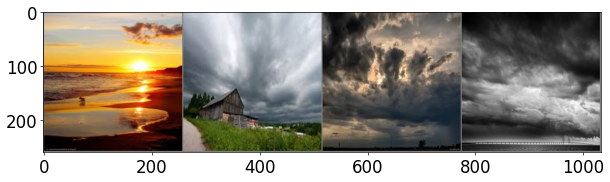

['Sunrise', 'Cloudy', 'Cloudy', 'Cloudy']


In [8]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size' : 20})

def imshow(input) :
  # torch.Tensor => numpy
  input = input.numpy().transpose((1, 2, 0))
  # undo image normalization
  mean = np.array([0.5, 0.5, 0.5])
  std = np.array([0.5, 0.5, 0.5])
  input = std * input + mean
  input = np.clip(input, 0, 1)
  # display images
  plt.imshow(input)
  plt.show()

class_names = {
    0 : "Cloudy",
    1 : "Rain",
    2 : "Shine",
    3 : "Sunrise"
}

# load a batch of train image
iterator = iter(train_dataloader)

# visualize a batch of train image
imgs, labels = next(iterator)
out = torchvision.utils.make_grid(imgs[:4])
imshow(out)
print([class_names[labels[i].item()] for i in range(4)])

### **딥러닝 모델 학습(Training)**
- 자신이 직접 정의한 뉴럴 네트워크를 이용하여 데이터 세트에 대한 학습이 가능하다.
  - 레이어의 깊이를 늘려 가며, 파라미터의 개수를 증가시킬 수 있다.

In [9]:
class Model1(nn.Module) :
  def __init__(self) :
    super(Model1, self).__init__()
    self.linear1 = nn.Linear(256 * 256 * 3, 4)
    self.flatten = nn.Flatten()

  def forward(self, x) :
    x = self.flatten(x)
    x = self.linear1(x)
    return x

class Model2(nn.Module) :
  def __init__(self) :
    super(Model2, self).__init__()
    self.linear1 = nn.Linear(256 * 256 * 3, 64)
    self.linear2 = nn.Linear(64, 4)
    self.flatten = nn.Flatten()

  def forward(self, x) :
    x = self.flatten(x)
    x = self.linear1(x)
    x = self.linear2(x)
    return x

class Model3(nn.Module) :
  def __init__(self) :
    super(Model3, self).__init__()
    self.linear1 = nn.Linear(256 * 256 * 3, 128)
    self.dropout1 = nn.Dropout(0.5)
    self.linear2 = nn.Linear(128, 64)
    self.dropout2 = nn.Dropout(0.5)
    self.linear3 = nn.Linear(64, 32)
    self.dropout3 = nn.Dropout(0.5)
    self.linear4 = nn.Linear(32, 4)
    self.flatten = nn.Flatten()

  def forward(self, x) :
    x = self.flatten(x)
    x = F.relu(self.linear1(x))
    x = self.dropout1(x)
    x = F.relu(self.linear2(x))
    x = self.dropout2(x)
    x = F.relu(self.linear3(x))
    x = self.dropout3(x)
    x = self.linear4(x)
    return x

In [10]:
import time

def train() :
  start_time = time.time()
  print(f"[Epoch : {epoch + 1} - Training]")
  model.train()
  total = 0
  running_loss = 0.0
  running_corrects = 0

  for i, batch in enumerate(train_dataloader) :
    imgs, labels = batch
    imgs, labels = imgs.cuda(), labels.cuda()

    outputs = model(imgs)
    optimizer.zero_grad()
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    loss.backward()
    optimizer.step()

    total += labels.shape[0]
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

    if i % log_step == log_step - 1 :
      print(f"[Batch : {i + 1}] running train loss : {running_loss / total}, running train accuracy : {running_corrects / total}")

  print(f'train loss : {running_loss / total}, accuracy : {running_corrects / total}')
  print("elpased time : ", time.time() - start_time)
  return running_loss / total, (running_corrects / total).item()

def validate() :
  start_time = time.time()
  print(f'[Epoch : {epoch + 1} - Validation]')
  model.eval()
  total = 0
  running_loss = 0.0
  running_corrects = 0

  for i, batch in enumerate(val_dataloader) :
    imgs, labels = batch
    imgs, labels = imgs.cuda(), labels.cuda()

    with torch.no_grad() :
      outputs = model(imgs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)

    total += labels.shape[0]
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

    if (i == 0) or (i % log_step == log_step - 1) :
      print(f'[Batch : {i + 1}] running val loss : {running_loss / total}, running val accuracy : {running_corrects / total}')

  print(f'val loss : {running_loss / total}, accuracy : {running_corrects / total}')
  print('elapsed time :', time.time() - start_time)
  return running_loss / total, (running_corrects / total).item()

def test() :
  start_time = time.time()
  print(f'[Test]')
  model.eval()
  total = 0
  running_loss = 0.0
  running_corrects = 0

  for i, batch in enumerate(test_dataloader) :
    imgs, labels = batch
    imgs, labels = imgs.cuda(), labels.cuda()

    with torch.no_grad() :
      outputs = model(imgs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)

    total += labels.shape[0]
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

    if (i == 0) or (i % log_step == log_step - 1) :
      print(f'[Batch : {i + 1}] running test loss : {running_loss / total}, running test accuracy : {running_corrects / total}')

  print(f'test loss : {running_loss / total}, accuracy : {running_corrects / total}')
  print('elapsed time :', time.time() - start_time)
  return running_loss / total, (running_corrects / total).item()

In [11]:
import time

def adjust_learning_rate(optimizer, epoch) :
  lr = learning_rate
  if epoch >= 3 :
    lr /= 10
  if epoch >= 7 :
    lr /= 10
  for param_group in optimizer.param_groups :
    param_group['lr'] = lr

### **학습 결과 확인하기**
- 학습 결과를 시각화하여 정상적으로 모델이 학습되었는지 확인한다.

[Epoch : 1 - Training]
train loss : 0.31574268959186697, accuracy : 0.5822222232818604
elpased time :  5.156428813934326
[Epoch : 1 - Validation]
[Batch : 1] running val loss : 0.2426569163799286, running val accuracy : 0.734375
val loss : 0.3439370104547083, accuracy : 0.6745561957359314
elapsed time : 2.057851552963257
[Info] best validation accuracy!
[Epoch : 2 - Training]
train loss : 0.28927906884087456, accuracy : 0.7022222280502319
elpased time :  4.859215259552002
[Epoch : 2 - Validation]
[Batch : 1] running val loss : 0.16402789950370789, running val accuracy : 0.78125
val loss : 0.15934870511117066, accuracy : 0.7988165616989136
elapsed time : 1.4539341926574707
[Info] best validation accuracy!
[Epoch : 3 - Training]
train loss : 0.20527757362083152, accuracy : 0.7140740752220154
elpased time :  5.460275888442993
[Epoch : 3 - Validation]
[Batch : 1] running val loss : 0.12765276432037354, running val accuracy : 0.796875
val loss : 0.16121446733644024, accuracy : 0.75147932767

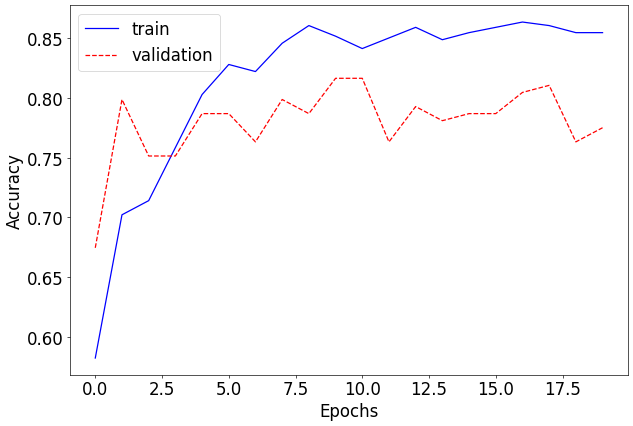

In [13]:
learning_rate = 0.01
log_step = 20

model = Model1()
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

num_epochs = 20
best_val_acc = 0
best_epoch = 0

history = []
accuracy = []
for epoch in range(num_epochs) :
  adjust_learning_rate(optimizer, epoch)
  train_loss, train_acc = train()
  val_loss, val_acc = validate()
  history.append((train_loss, val_loss))
  accuracy.append((train_acc, val_acc))

  if val_acc > best_val_acc :
    print("[Info] best validation accuracy!")
    best_val_acc = val_acc
    best_epoch = epoch
    torch.save(model.state_dict(), f"best_checkpoint_epoch_{epoch + 1}.pth")

torch.save(model.state_dict(), f"last_checkpoint_epoch_{num_epochs}.pth")

plt.plot([x[0] for x in accuracy], 'b', label = 'train')
plt.plot([x[1] for x in accuracy], 'r--', label = 'validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

test_loss, test_accuracy = test()
print(f"Test loss : {test_loss : .8f}")
print(f"Test accuracy : {test_accuracy * 100.:.2f}%")

[Epoch : 1 - Training]
train loss : 0.12057310157352023, accuracy : 0.5111110806465149
elpased time :  6.2605297565460205
[Epoch : 1 - Validation]
[Batch : 1] running val loss : 0.05399696156382561, running val accuracy : 0.625
val loss : 0.06067385052788187, accuracy : 0.5739644765853882
elapsed time : 1.4726998805999756
[Info] best validation accuracy!
[Epoch : 2 - Training]
train loss : 0.2681578395984791, accuracy : 0.49037036299705505
elpased time :  5.0888471603393555
[Epoch : 2 - Validation]
[Batch : 1] running val loss : 0.19937726855278015, running val accuracy : 0.703125
val loss : 0.2598061589799689, accuracy : 0.6449704170227051
elapsed time : 2.1219823360443115
[Info] best validation accuracy!
[Epoch : 3 - Training]
train loss : 0.39157207489013673, accuracy : 0.5392592549324036
elpased time :  4.979378700256348
[Epoch : 3 - Validation]
[Batch : 1] running val loss : 0.7049961090087891, running val accuracy : 0.671875
val loss : 0.9714056613177238, accuracy : 0.62721896171

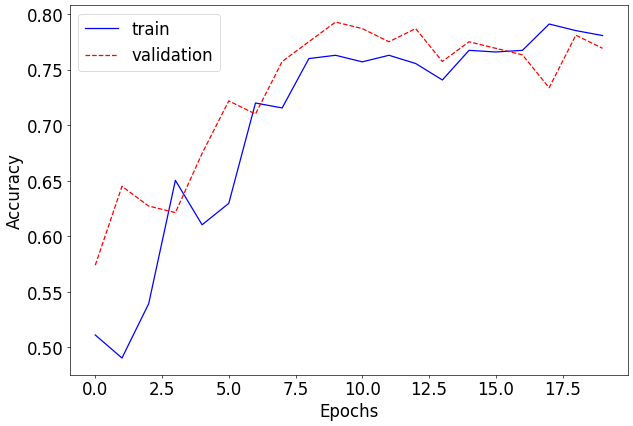

In [14]:
learning_rate = 0.01
log_step = 20

model = Model2()
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

num_epochs = 20
best_val_acc = 0
best_epoch = 0

history = []
accuracy = []
for epoch in range(num_epochs) :
  adjust_learning_rate(optimizer, epoch)
  train_loss, train_acc = train()
  val_loss, val_acc = validate()
  history.append((train_loss, val_loss))
  accuracy.append((train_acc, val_acc))

  if val_acc > best_val_acc :
    print("[Info] best validation accuracy!")
    best_val_acc = val_acc
    best_epoch = epoch
    torch.save(model.state_dict(), f"best_checkpoint_epoch_{epoch + 1}.pth")

torch.save(model.state_dict(), f"last_checkpoint_epoch_{num_epochs}.pth")

plt.plot([x[0] for x in accuracy], 'b', label = 'train')
plt.plot([x[1] for x in accuracy], 'r--', label = 'validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

test_loss, test_accuracy = test()
print(f"Test loss : {test_loss : .8f}")
print(f"Test accuracy : {test_accuracy * 100.:.2f}%")

[Epoch : 1 - Training]
train loss : 0.021290713769418223, accuracy : 0.3762962818145752
elpased time :  6.470999240875244
[Epoch : 1 - Validation]
[Batch : 1] running val loss : 0.011919116601347923, running val accuracy : 0.75
val loss : 0.015246267854814699, accuracy : 0.6804733872413635
elapsed time : 1.4322445392608643
[Info] best validation accuracy!
[Epoch : 2 - Training]
train loss : 0.019067139978762027, accuracy : 0.48592591285705566
elpased time :  5.232180595397949
[Epoch : 2 - Validation]
[Batch : 1] running val loss : 0.010710659436881542, running val accuracy : 0.703125
val loss : 0.013094892868628869, accuracy : 0.6863905191421509
elapsed time : 1.6153452396392822
[Info] best validation accuracy!
[Epoch : 3 - Training]
train loss : 0.01565968292730826, accuracy : 0.5614814758300781
elpased time :  5.312993764877319
[Epoch : 3 - Validation]
[Batch : 1] running val loss : 0.00965232402086258, running val accuracy : 0.75
val loss : 0.01239430057931934, accuracy : 0.72781068

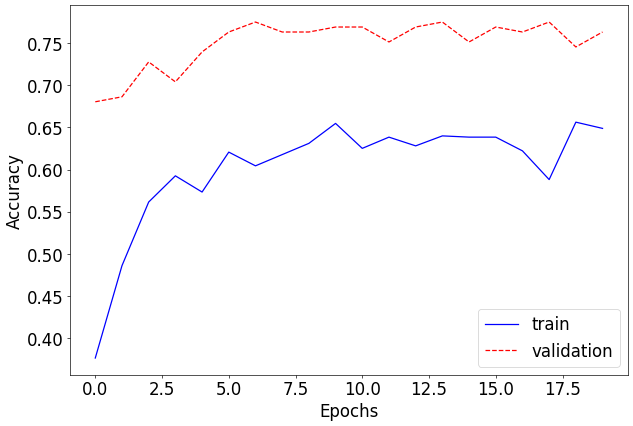

In [15]:
learning_rate = 0.01
log_step = 20

model = Model3()
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

num_epochs = 20
best_val_acc = 0
best_epoch = 0

history = []
accuracy = []
for epoch in range(num_epochs) :
  adjust_learning_rate(optimizer, epoch)
  train_loss, train_acc = train()
  val_loss, val_acc = validate()
  history.append((train_loss, val_loss))
  accuracy.append((train_acc, val_acc))

  if val_acc > best_val_acc :
    print("[Info] best validation accuracy!")
    best_val_acc = val_acc
    best_epoch = epoch
    torch.save(model.state_dict(), f"best_checkpoint_epoch_{epoch + 1}.pth")

torch.save(model.state_dict(), f"last_checkpoint_epoch_{num_epochs}.pth")

plt.plot([x[0] for x in accuracy], 'b', label = 'train')
plt.plot([x[1] for x in accuracy], 'r--', label = 'validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

test_loss, test_accuracy = test()
print(f"Test loss : {test_loss : .8f}")
print(f"Test accuracy : {test_accuracy * 100.:.2f}%")